In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics, sklearn.mixture
import plotly.express as px
# from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
def create_interactive_histograms(df, attributes=['released_year', 'released_month'], x_axis='cluster_id', width=1000, height=600):
    for atr in attributes:
        fig = px.histogram(
            df,
            x=x_axis,
            color=atr,
            barmode='group',
            title=f'Distribution of Values by {atr}',
            labels={x_axis: 'Cluster ID', 'count': 'Count'},
            width=width,
            height=height
        )
        fig.update_layout(
            legend=dict(yanchor="top", y=0.99, xanchor="left", x=1.05, title=f"{atr}"),
            xaxis_title=x_axis.capitalize(),
            yaxis_title="Count"
        )
        fig.show()

# Kompletní dataset - Spotify 2023

In [3]:
df_full = pd.read_csv('spotify-2023.csv', encoding='ISO-8859-1')
df_full.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


Zde vidímě kolik kategoriálních atributů se nachází ve zvoleném datasetu.

In [4]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

Pro začátek je dobré zjistit zda a popřípadě kolik se v datasetu nachází chybějících hodnot.

In [5]:
df_full.isna().sum().sort_values(ascending=False)

key                     95
in_shazam_charts        50
track_name               0
artist(s)_name           0
released_month           0
released_day             0
artist_count             0
released_year            0
in_spotify_charts        0
in_spotify_playlists     0
streams                  0
in_apple_playlists       0
in_deezer_playlists      0
in_apple_charts          0
in_deezer_charts         0
bpm                      0
mode                     0
danceability_%           0
valence_%                0
energy_%                 0
acousticness_%           0
instrumentalness_%       0
liveness_%               0
speechiness_%            0
dtype: int64

# Mnou zvolený subset z původního datasetu
## Popis atributů datasetu
- **artist_count**: Počet interpretů, kteří se podíleli na skladbě.
- **released_year**: Rok vydání skladby.
- **released_month**: Měsíc vydání skladby.
- **in_spotify_playlists**: Počet Spotify playlistů, ve kterých je skladba zahrnuta.
- **in_spotify_charts**: Přítomnost a pozice skladby v žebříčcích na Spotify.
- **streams**: Celkový počet přehrání skladby na Spotify.
- **in_apple_playlists**: Počet Apple Music playlistů, ve kterých je skladba zahrnuta.
- **in_apple_charts**: Přítomnost a pozice skladby v žebříčcích na Apple Music.
- **in_deezer_playlists**: Počet Deezer playlistů, ve kterých je skladba zahrnuta.
- **in_deezer_charts**: Přítomnost a pozice skladby v žebříčcích na Deezeru.
- **bpm**: Počet úderů za minutu (beats per minute), měřítko tempa skladby.
- **mode**: Režim skladby (durový nebo mollový).
- **danceability**: Procento určující, jak vhodná je skladba pro tanec.
- **valence**: Pozitivita hudebního obsahu skladby.
- **energy**: Vnímaná úroveň energie skladby.
- **acousticness**: Míra akustického zvuku ve skladbě.
- **instrumentalness**: Míra instrumentálního obsahu skladby.
- **liveness**: Přítomnost prvků živého vystoupení.
- **speechiness**: Míra mluveného slova ve skladbě.


## EDA

In [6]:
df = df_full.copy()

In [7]:
df.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

Jelikož víme, že atributy symbolizují % hodnoty tak jen upravíme název pro lepší čitelnost v následné vizuální reprezentaci.

In [9]:
columns_to_rename = [
    'danceability_%', 'energy_%', 'valence_%',
    'acousticness_%', 'instrumentalness_%', 'liveness_%', 'speechiness_%'
]

df.rename(columns=lambda col: col.replace('_%', '') if col in columns_to_rename else col, inplace=True)

### Zobrazení distribuce pro numerické atributy.



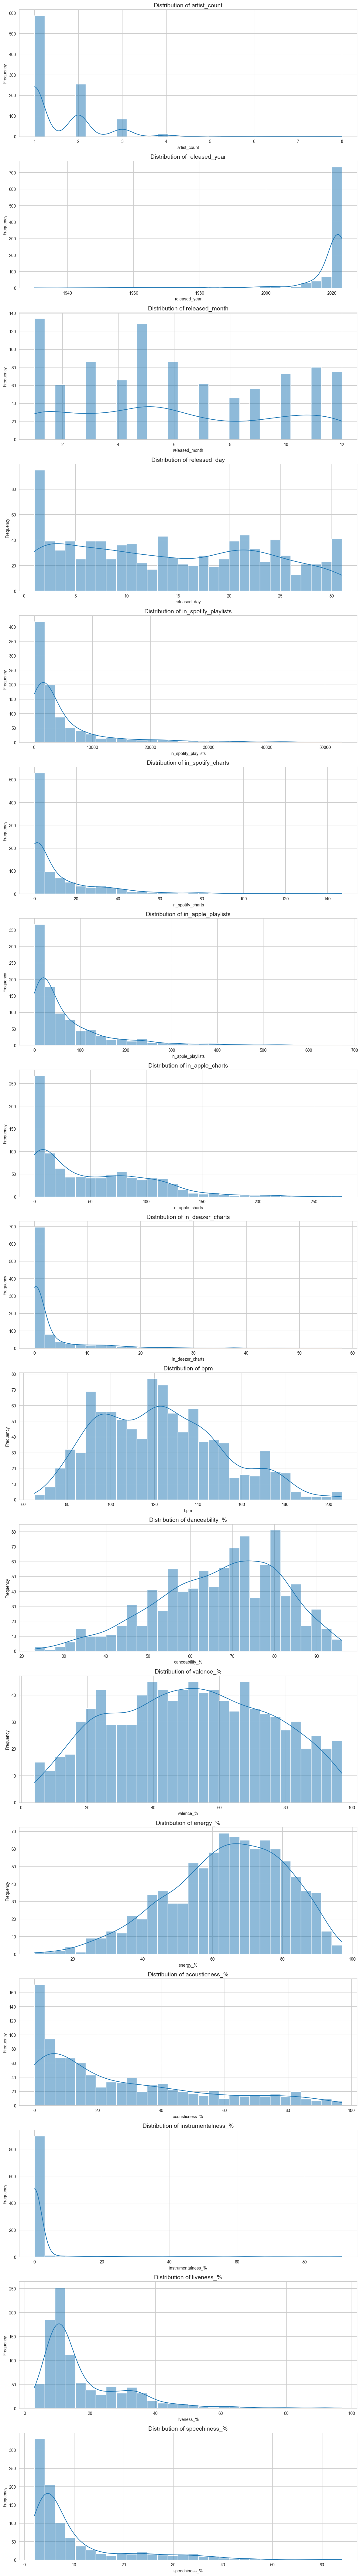

In [10]:
sns.set_style("whitegrid")
numeric_features = df_full.select_dtypes(include=['number']).columns
fig, axes = plt.subplots(nrows=len(numeric_features), figsize=(12, 5 * len(numeric_features)))

for i, feature in enumerate(numeric_features):
    sns.histplot(df_full[feature], ax=axes[i], bins=30, kde=True)
    axes[i].set_title(f'Distribution of {feature}', fontsize=14)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Korelační matice pro všechny numerické atributy

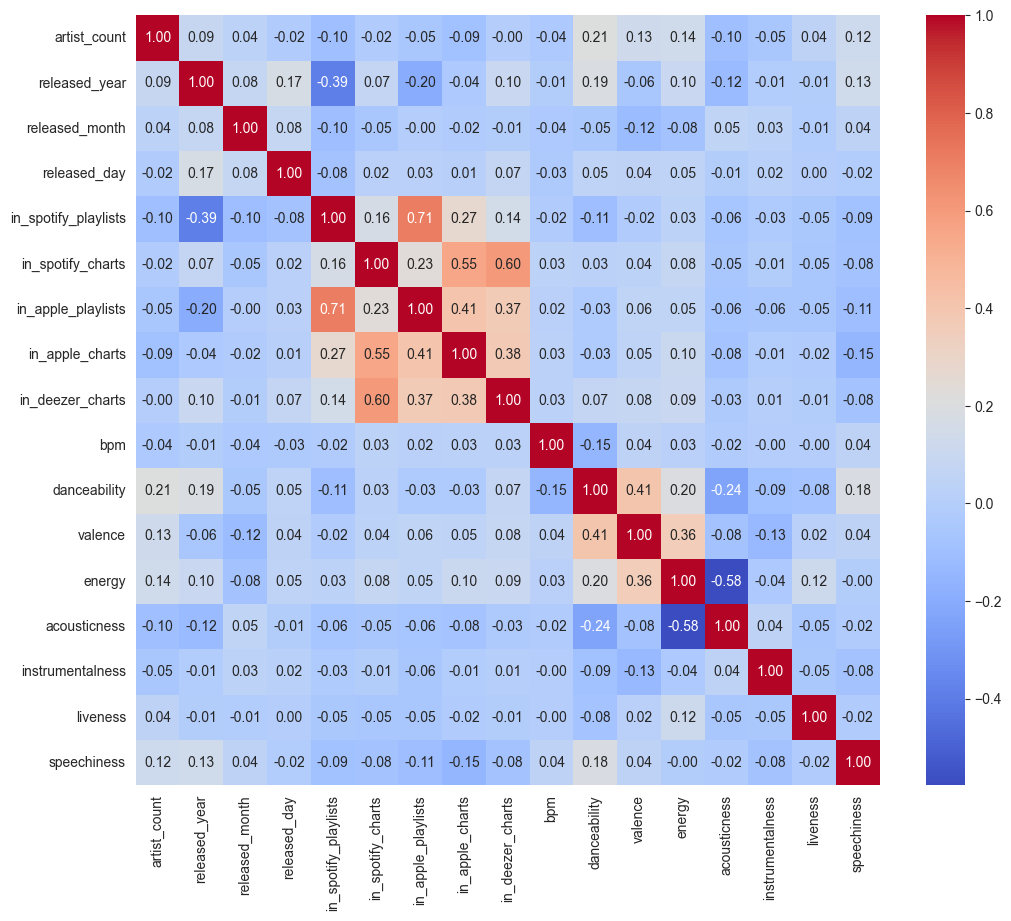

In [11]:
df_numeric = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 10))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

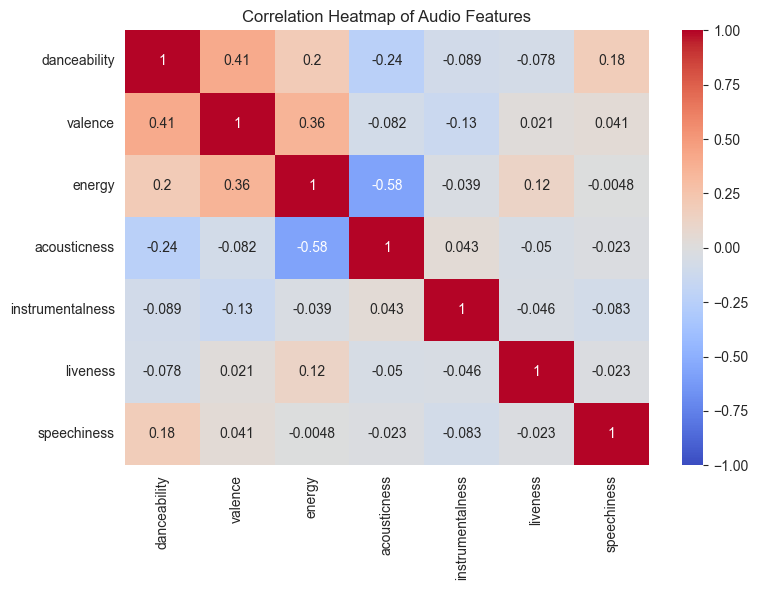

In [12]:
plt.figure(figsize = (8, 6))
corr = df[['danceability','valence', 'energy', 'acousticness', 'instrumentalness','liveness', 'speechiness']].corr()
sns.heatmap(corr, annot = True, cmap = 'coolwarm', vmin =- 1, vmax = 1)
plt.title('Correlation Heatmap of Audio Features')
plt.tight_layout()
plt.show()

## Preprocessing dat

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

V první řadě by bylo dobré převést atribut `streams` na numerické, jelikož tento atribut má symbolizovat počet přehrání.

In [14]:
# df['streams'] = pd.to_numeric(df['streams']) -> zde dostaneme chybu pro pozici df.iloc[574] proto je tento řádek zakomentován

Zde vidíme záznam č. 574, který má ve sloupci streams nesmyslnou hodnotu, tedy je zapotřebí tento záznam odstranit.

In [15]:
df.iloc[574]

track_name                            Love Grows (Where My Rosemary Goes)
artist(s)_name                                          Edison Lighthouse
artist_count                                                            1
released_year                                                        1970
released_month                                                          1
released_day                                                            1
in_spotify_playlists                                                 2877
in_spotify_charts                                                       0
streams                 BPM110KeyAModeMajorDanceability53Valence75Ener...
in_apple_playlists                                                     16
in_apple_charts                                                         0
in_deezer_playlists                                                    54
in_deezer_charts                                                        0
in_shazam_charts                      

In [16]:
df.drop(index=574, inplace = True)

Nyní lze bez další problémů provést konverzi sloupce `streams` na numerické hodnoty int64.

In [17]:
df['streams'] = pd.to_numeric(df['streams'])

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            952 non-null    object
 1   artist(s)_name        952 non-null    object
 2   artist_count          952 non-null    int64 
 3   released_year         952 non-null    int64 
 4   released_month        952 non-null    int64 
 5   released_day          952 non-null    int64 
 6   in_spotify_playlists  952 non-null    int64 
 7   in_spotify_charts     952 non-null    int64 
 8   streams               952 non-null    int64 
 9   in_apple_playlists    952 non-null    int64 
 10  in_apple_charts       952 non-null    int64 
 11  in_deezer_playlists   952 non-null    object
 12  in_deezer_charts      952 non-null    int64 
 13  in_shazam_charts      902 non-null    object
 14  bpm                   952 non-null    int64 
 15  key                   857 non-null    object


Jak je vidět z datových typů v předchozí tabulce tak hodnoty ve sloupci `in_deezer_playlists` jsou typu object, přestože bychom očekávaly numerické hodnoty.
Toto je zapříčiněno tím, že hodnoty překračující 1 tisíc jsou zapsány ve formátu 1,000 a proto je zapotřebí správně naformátovat hodnoty a tím docílíme numerizace tohoto konkrétního sloupce.

In [19]:
df['in_deezer_playlists'] = df['in_deezer_playlists'].str.replace(',', '').astype(int)

Zde už vidíme, že sloupec je správně označen a nese hodnoty typu int64.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 952 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            952 non-null    object
 1   artist(s)_name        952 non-null    object
 2   artist_count          952 non-null    int64 
 3   released_year         952 non-null    int64 
 4   released_month        952 non-null    int64 
 5   released_day          952 non-null    int64 
 6   in_spotify_playlists  952 non-null    int64 
 7   in_spotify_charts     952 non-null    int64 
 8   streams               952 non-null    int64 
 9   in_apple_playlists    952 non-null    int64 
 10  in_apple_charts       952 non-null    int64 
 11  in_deezer_playlists   952 non-null    int64 
 12  in_deezer_charts      952 non-null    int64 
 13  in_shazam_charts      902 non-null    object
 14  bpm                   952 non-null    int64 
 15  key                   857 non-null    object


Kontrola zda se v datasetu vyskytují prázdné hodnoty, které by mohly být problémem.

In [21]:
df.isna().sum().sort_values(ascending=False)

key                     95
in_shazam_charts        50
track_name               0
artist(s)_name           0
released_month           0
released_day             0
artist_count             0
released_year            0
in_spotify_charts        0
in_spotify_playlists     0
streams                  0
in_apple_playlists       0
in_deezer_playlists      0
in_apple_charts          0
in_deezer_charts         0
bpm                      0
mode                     0
danceability             0
valence                  0
energy                   0
acousticness             0
instrumentalness         0
liveness                 0
speechiness              0
dtype: int64

Ve výše uvedené tabulce vidíme, že ve sloupcích `key` a `in_shazam_charts` chybí hodnoty a jelikož ani jeden z těchto sloupců není kritický pro shlukovací analýzu a chybějící data nejsme schopni doplnit tak, abychom nezkreslily následné shlukování tak je z datasetu odstraníme. Zároveň víme, že pro naše účely není zapotřebí znát jména a autory písni tak odstraníme i tyto sloupce. V neposlední řadě jsem se rozhodl odstranit atribut `released_day`.

In [22]:
df.drop(columns = ['in_shazam_charts', 'released_day', 'track_name', 'artist(s)_name', 'key'], inplace = True)

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
artist_count,952.0,1.556723e+00,8.933314e-01,1.0,1.000000e+00,1.0,2.000000e+00,8.000000e+00
released_year,952.0,2.018289e+03,1.101140e+01,1930.0,2.020000e+03,2022.0,2.022000e+03,2.023000e+03
released_month,952.0,6.038866e+00,3.564571e+00,1.0,3.000000e+00,6.0,9.000000e+00,1.200000e+01
in_spotify_playlists,952.0,5.202565e+03,7.901401e+03,31.0,8.745000e+02,2216.5,5.573750e+03,5.289800e+04
in_spotify_charts,952.0,1.202206e+01,1.958241e+01,0.0,0.000000e+00,3.0,1.600000e+01,1.470000e+02
streams,952.0,5.141374e+08,5.668569e+08,2762.0,1.416362e+08,290530915.0,6.738690e+08,3.703895e+09
in_apple_playlists,952.0,6.786660e+01,8.647059e+01,0.0,1.300000e+01,34.0,8.800000e+01,6.720000e+02
in_apple_charts,952.0,5.196324e+01,5.062885e+01,0.0,7.000000e+00,38.5,8.700000e+01,2.750000e+02
in_deezer_playlists,952.0,3.855357e+02,1.131079e+03,0.0,1.300000e+01,44.0,1.642500e+02,1.236700e+04
in_deezer_charts,952.0,2.669118e+00,6.038152e+00,0.0,0.000000e+00,0.0,2.000000e+00,5.800000e+01


Kontrola zda se v našem datasetu neobjevují duplicitní hodnoty.

In [24]:
df.duplicated().sum()

np.int64(0)

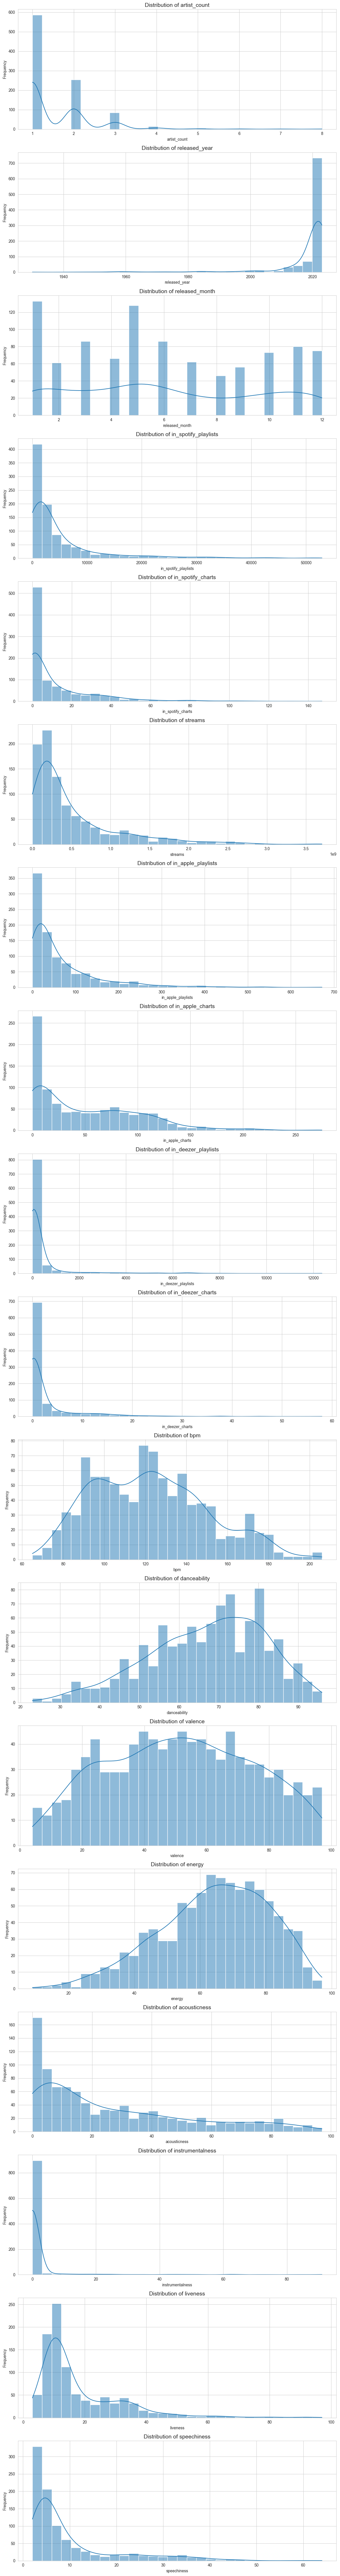

In [25]:
sns.set_style("whitegrid")
numeric_features = df.select_dtypes(include=['number']).columns
fig, axes = plt.subplots(nrows=len(numeric_features), figsize=(12, 5 * len(numeric_features)))

for i, feature in enumerate(numeric_features):
    sns.histplot(df[feature], ax=axes[i], bins=30, kde=True)
    axes[i].set_title(f'Distribution of {feature}', fontsize=14)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Standardizace a power transformace dat
- Tyto transformace využiji pro taková data, která chci, aby byla normalizovaná
- Tím dosáhnu stabilizování celkového rozptylu hodnot a redukuju potenciání zkreslení výsledků.

In [26]:
df_encoded = df.copy()
df_encoded['in_spotify_playlists'] = sklearn.preprocessing.power_transform(df[['in_spotify_playlists']])
df_encoded['in_spotify_charts'] = sklearn.preprocessing.power_transform(df[['in_spotify_charts']])
df_encoded['streams'] = sklearn.preprocessing.power_transform(df[['streams']])
df_encoded['in_apple_playlists'] = sklearn.preprocessing.power_transform(df[['in_apple_playlists']])
df_encoded['in_apple_charts'] = sklearn.preprocessing.power_transform(df[['in_apple_charts']])
df_encoded['in_deezer_playlists'] = sklearn.preprocessing.power_transform(df[['in_deezer_playlists']])
df_encoded['in_deezer_charts'] = sklearn.preprocessing.power_transform(df[['in_deezer_charts']])
df_encoded['acousticness'] = sklearn.preprocessing.power_transform(df[['acousticness']])
df_encoded['instrumentalness'] = sklearn.preprocessing.power_transform(df[['instrumentalness']])
df_encoded['liveness'] = sklearn.preprocessing.power_transform(df[['liveness']])
df_encoded['speechiness'] = sklearn.preprocessing.power_transform(df[['speechiness']])

In [27]:
scaler = sklearn.preprocessing.StandardScaler()
df_encoded['bpm'] = scaler.fit_transform(df[['bpm']])
df_encoded['danceability'] = scaler.fit_transform(df[['danceability']])
df_encoded['energy'] = scaler.fit_transform(df[['energy']])
df_encoded['valence'] = scaler.fit_transform(df[['valence']])

### One-hot encoding
- Atributy jako rok a měsíc převedeme na kategoriální s pomocí one-hot encodingu.

In [28]:
df_encoded = df_encoded.join(pd.get_dummies(df['released_year'], prefix='released_year'))
df_encoded = df_encoded.drop(columns=['released_year'])
df_encoded = df_encoded.join(pd.get_dummies(df['released_month'], prefix='released_month'))
df_encoded = df_encoded.drop(columns=['released_month'])

### Detailní pohled na distribuci atributu `mode`

mode
Major    549
Minor    403
Name: count, dtype: int64


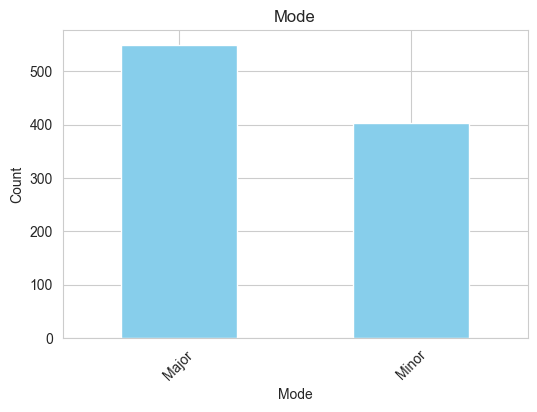

In [29]:
column_counts = df['mode'].value_counts()
print(column_counts)
plt.figure(figsize=(6, 4))
column_counts.plot(kind='bar', color='skyblue')
plt.title('Mode')
plt.xlabel('Mode')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

<Axes: ylabel='count'>

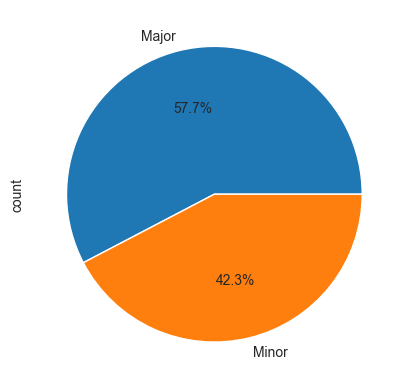

In [30]:
df["mode"].value_counts().plot(kind="pie",autopct="%1.1f%%")

In [31]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_encoded['mode'] = label_encoder.fit_transform(df['mode'])

In [32]:
df_encoded['mode'].value_counts()

mode
0    549
1    403
Name: count, dtype: int64

### Pohled na distribuci jednotlivých atributů po provedení preprocessingu

In [33]:
df_encoded.head()

,artist_count,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,bpm,mode,...,released_month_3,released_month_4,released_month_5,released_month_6,released_month_7,released_month_8,released_month_9,released_month_10,released_month_11,released_month_12
0,2,-1.053951,1.877767,-0.712259,0.144878,2.139934,-0.018662,1.623384,0.087202,0,...,False,False,False,False,True,False,False,False,False,False
1,1,-0.312466,1.448925,-0.757901,0.230017,1.241775,0.113907,1.684169,-1.089065,0,...,True,False,False,False,False,False,False,False,False,False
2,1,-0.352926,1.784631,-0.720301,0.777092,1.826246,0.344394,1.684169,0.550580,0,...,False,False,False,True,False,False,False,False,False,False
3,1,0.942117,1.739802,0.886378,0.957840,1.826246,0.502926,1.658532,1.691202,0,...,False,False,False,False,False,True,False,False,False,False
4,1,0.254596,1.466101,-0.053041,0.682303,1.301381,0.321680,1.694546,0.764446,1,...,False,False,True,False,False,False,False,False,False,False


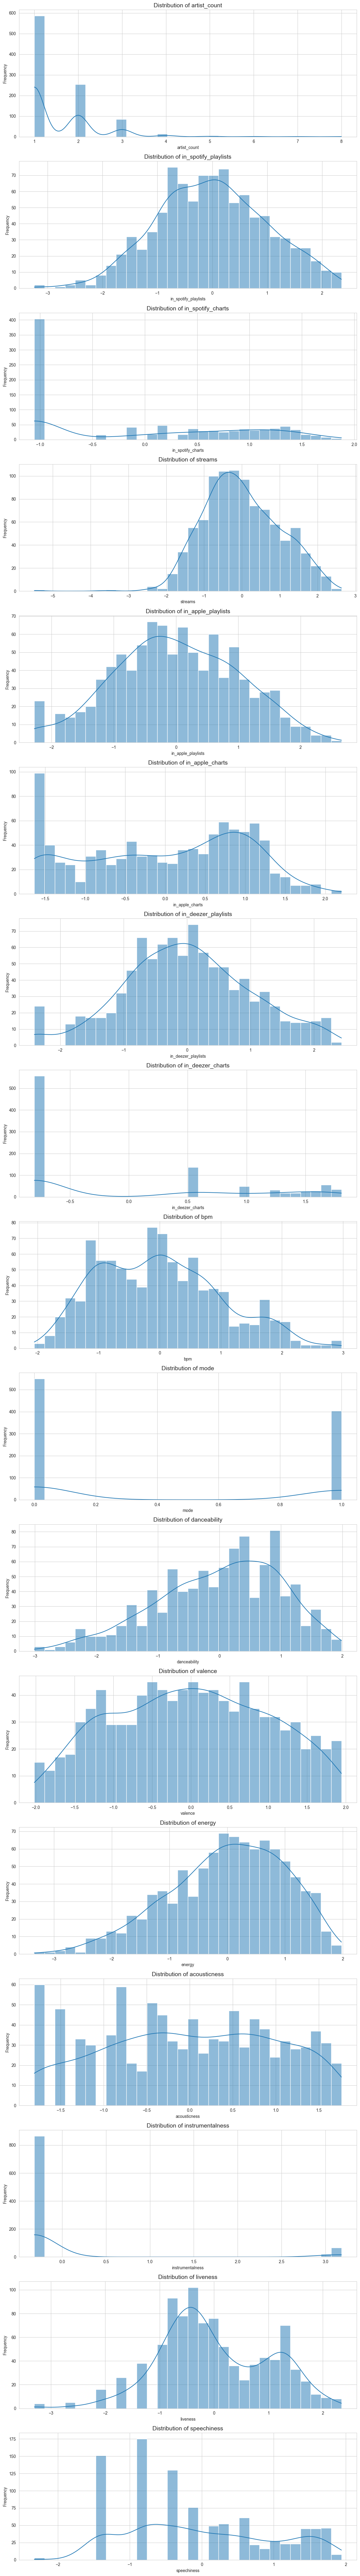

In [34]:
sns.set_style("whitegrid")
numeric_features = df_encoded.select_dtypes(include=['number']).columns
fig, axes = plt.subplots(nrows=len(numeric_features), figsize=(12, 5 * len(numeric_features)))

for i, feature in enumerate(numeric_features):
    sns.histplot(df_encoded[feature], ax=axes[i], bins=30, kde=True)
    axes[i].set_title(f'Distribution of {feature}', fontsize=14)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Klasifikace pro atribut `streams`


### Výběr predikovaného atributu a jeho zpracování

V této analýze bude predikovaným atributem **`streams`**, který byl po předzpracování dat transformován pomocí power transformace. Tato volba byla zvolena z následujících důvodů:

1. **Problém s původní distribucí dat**:  
   Distribuce atributu **`streams`** byla značně zkreslená (pravostranná šikmost), což je způsobeno vysokým počtem skladeb s nízkým počtem přehrání a malým počtem extrémně populárních skladeb s miliardami přehrání. V takto zkreslené distribuci by se model mohl zaměřit převážně na extrémně populární skladby, zatímco rozdíly mezi méně populárními skladbami by byly ignorovány. To by vedlo k nižší přesnosti modelu u skladeb s průměrnou popularitou.

2. **Výhody použití transformovaných hodnot**:  
   Transformace hodnot pomocí power transformace snížila váhu extrémních hodnot a vyrovnala distribuci dat. Tím se zvýraznily rozdíly mezi skladbami s nižšími počty přehrání, což umožňuje modelu učit se jemnější rozdíly mezi skladbami napříč celou škálou. Tato metoda tak zlepšuje predikční schopnosti modelu u méně populárních skladeb a přispívá k celkově lepšímu výkonu modelu.

Transformace tedy zajišťuje, že výsledný model bude rovnoměrněji zohledňovat skladby napříč celým spektrem popularity a poskytne přesnější výsledky.

Dále jsem provedl tzv. **feature engineering** pro rozdělení atributu **`streams`** na jednotlivé kategorie popularity za pomoci kvartilového rozdělení.


In [35]:
df_encoded['popularity_category'] = pd.qcut(df_encoded['streams'], q=4, labels=['Unpopular', 'Average', 'Popular', 'Most Popular'])

print(df_encoded['popularity_category'].value_counts())

popularity_category
Unpopular       238
Average         238
Popular         238
Most Popular    238
Name: count, dtype: int64


In [36]:
df_encoded.head()

,artist_count,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,in_apple_charts,in_deezer_playlists,in_deezer_charts,bpm,mode,...,released_month_4,released_month_5,released_month_6,released_month_7,released_month_8,released_month_9,released_month_10,released_month_11,released_month_12,popularity_category
0,2,-1.053951,1.877767,-0.712259,0.144878,2.139934,-0.018662,1.623384,0.087202,0,...,False,False,False,True,False,False,False,False,False,Unpopular
1,1,-0.312466,1.448925,-0.757901,0.230017,1.241775,0.113907,1.684169,-1.089065,0,...,False,False,False,False,False,False,False,False,False,Unpopular
2,1,-0.352926,1.784631,-0.720301,0.777092,1.826246,0.344394,1.684169,0.550580,0,...,False,False,True,False,False,False,False,False,False,Unpopular
3,1,0.942117,1.739802,0.886378,0.957840,1.826246,0.502926,1.658532,1.691202,0,...,False,False,False,False,True,False,False,False,False,Most Popular
4,1,0.254596,1.466101,-0.053041,0.682303,1.301381,0.321680,1.694546,0.764446,1,...,False,True,False,False,False,False,False,False,False,Popular


In [37]:
song_data = df_encoded[['streams', 'popularity_category']]
song_data_sorted = song_data.sort_values(by='streams', ascending=False)
print(song_data_sorted)
song_data_sorted.to_csv('songs_streams_and_categories.csv', index=False)

      streams popularity_category
55   2.631419        Most Popular
179  2.582644        Most Popular
86   2.323409        Most Popular
620  2.313917        Most Popular
41   2.289654        Most Popular
..        ...                 ...
68  -2.320209           Unpopular
142 -2.448314           Unpopular
144 -2.466356           Unpopular
393 -3.574984           Unpopular
123 -5.487876           Unpopular

[952 rows x 2 columns]


In [38]:
def plot_feature_importance(X_train, best_model):
    feature_names = X_train.columns
    feature_importances = best_model.feature_importances_
    
    indices = np.argsort(feature_importances)[::-1]
    indices = [i for i in indices if feature_importances[i] > 0]
    
    print("\nDůležitost jednotlivých funkcí:")
    for i in indices:
        print(f"{feature_names[i]}: {feature_importances[i]}")
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(indices)), feature_importances[indices], align="center")
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.title("Důležitost jednotlivých funkcí (importance > 0)")
    plt.xlabel("Funkce")
    plt.ylabel("Důležitost")
    plt.tight_layout()
    plt.show()


Fitting 7 folds for each of 900 candidates, totalling 6300 fits
Nejlepší parametry: {'criterion': 'gini', 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'best'}
Nejlepší skóre na trénovací sadě: 0.9988277796994504

Classification Report na testovací sadě:
              precision    recall  f1-score   support

     Average       0.98      0.98      0.98        48
Most Popular       0.98      1.00      0.99        47
     Popular       0.98      0.98      0.98        48
   Unpopular       1.00      0.98      0.99        48

    accuracy                           0.98       191
   macro avg       0.98      0.98      0.98       191
weighted avg       0.98      0.98      0.98       191


Důležitost jednotlivých funkcí:
streams: 1.0


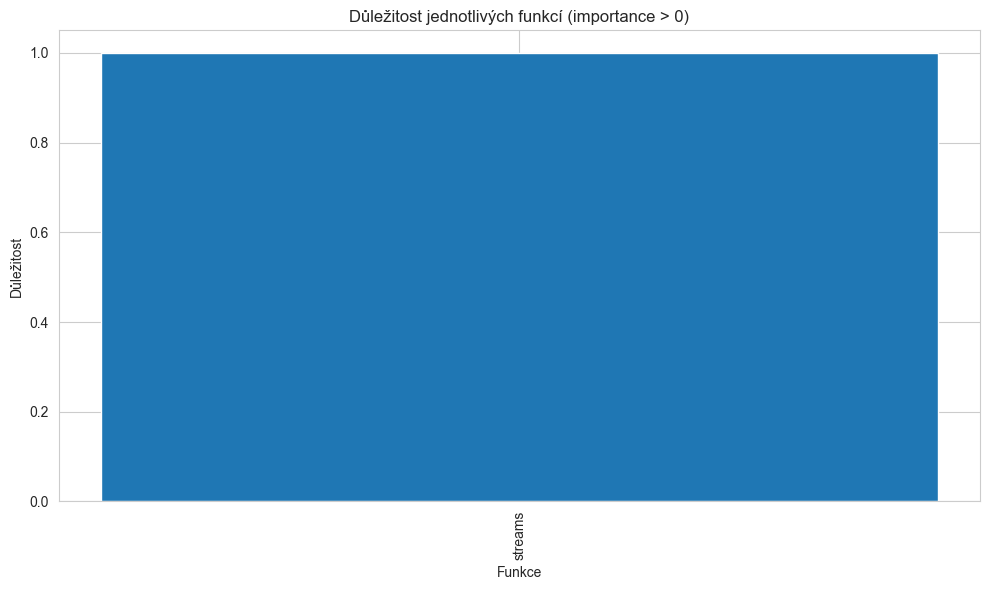

In [39]:
X = df_encoded.drop(columns=['popularity_category'])
y = df_encoded['popularity_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

dt_clf = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15, 20], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'max_features': [None, 'sqrt', 'log2']
}

kfold = KFold(n_splits=7, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=dt_clf, param_grid=param_grid, cv=kfold, scoring='f1_macro', n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print("Nejlepší parametry:", grid_search.best_params_)
print("Nejlepší skóre na trénovací sadě:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nClassification Report na testovací sadě:")
print(classification_report(y_test, y_pred))
plot_feature_importance(X_train, best_model)

### Vyloučení atributu `streams` z datové sady

Vzhledem k tomu, že provádíme klasifikaci pro atribut **`streams`**, je logické tento atribut vyloučit z datové sady. 

Analýza důležitosti atributů ukázala, že hodnota **`streams`** měla při klasifikaci nejvyšší možnou důležitost (**1.0**), zatímco ostatní atributy měly nulovou hodnotu důležitosti. 
To naznačuje, že klasifikátory se rozhodovaly výhradně na základě tohoto atributu, což může vést k jeho dominantnímu vlivu na model. Klasifikátory právě díky této dominanci dosahovaly téměř 100% přesností pro klasifikaci. Tedy původní logická hypotéza byla prokázána.

Pro zajištění smysluplné klasifikace, která zohledňuje i další atributy, je tedy vhodné **`streams`** z datové sady odstranit.

In [40]:
df_encoded.drop(columns=['streams'], inplace=True)

In [41]:
X = df_encoded.drop(columns=['popularity_category'])
y = df_encoded['popularity_category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

## DecisionTree

Výchozí DecisionTreeClassifier:
F1 skóre z křížové validace pro jednotlivé foldy (default): [0.5790633  0.61200662 0.59033999 0.64235119 0.59545613 0.49937486
 0.56996018]
Průměrné F1 skóre (default): 0.5840788958457649

Classification Report na testovací sadě (default):
              precision    recall  f1-score   support

     Average       0.56      0.60      0.58        48
Most Popular       0.78      0.74      0.76        47
     Popular       0.53      0.50      0.52        48
   Unpopular       0.71      0.73      0.72        48

    accuracy                           0.64       191
   macro avg       0.65      0.64      0.64       191
weighted avg       0.65      0.64      0.64       191

Fitting 7 folds for each of 900 candidates, totalling 6300 fits

Nejlepší parametry nalezené GridSearchCV:
{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}
Nejlepší F1 skóre na trénovací sadě (tuned): 0.6434190

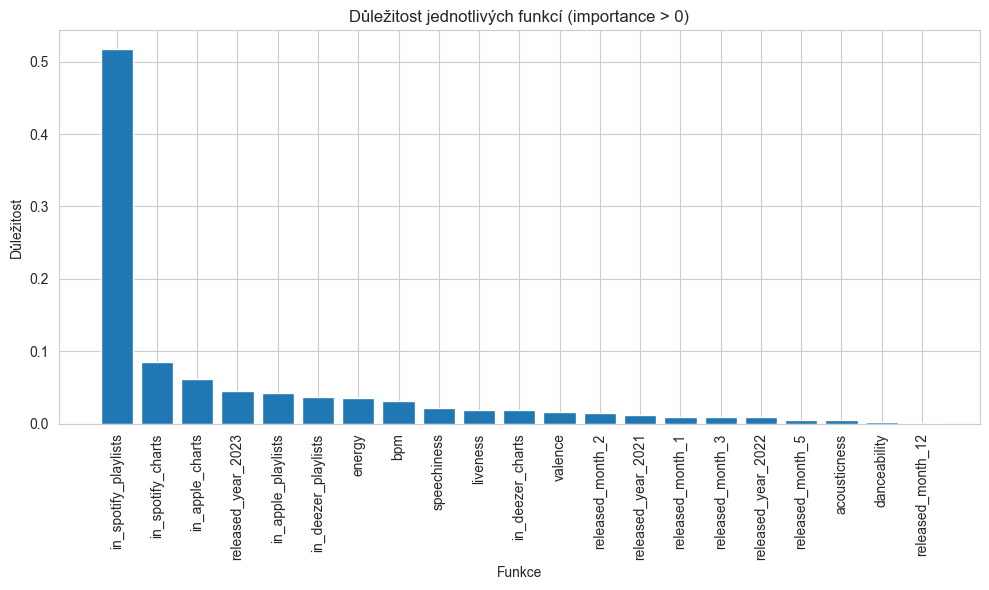

In [42]:
default_dt_clf = DecisionTreeClassifier(random_state=42)
cv_scores_default = cross_val_score(default_dt_clf, X_train, y_train, cv=KFold(n_splits=7, shuffle=True, random_state=42), scoring='f1_macro', n_jobs=-1)

print("Výchozí DecisionTreeClassifier:")
print("F1 skóre z křížové validace pro jednotlivé foldy (default):", cv_scores_default)
print("Průměrné F1 skóre (default):", cv_scores_default.mean())

default_dt_clf.fit(X_train, y_train)
y_pred_default = default_dt_clf.predict(X_test)

print("\nClassification Report na testovací sadě (default):")
print(classification_report(y_test, y_pred_default))

param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'max_features': [None, 'sqrt', 'log2']
}

kfold = KFold(n_splits=7, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=kfold,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("\nNejlepší parametry nalezené GridSearchCV:")
print(grid_search.best_params_)
print("Nejlepší F1 skóre na trénovací sadě (tuned):", grid_search.best_score_)

best_dt_clf = grid_search.best_estimator_
y_pred_tuned = best_dt_clf.predict(X_test)

print("\nClassification Report na testovací sadě (tuned):")
print(classification_report(y_test, y_pred_tuned))

plot_feature_importance(X_train, best_dt_clf)

## RandomForest

Výchozí RandomForest:
F1 skóre z křížové validace pro jednotlivé foldy (default): [0.68260615 0.71770944 0.62708294 0.71540305 0.69547335 0.61357128
 0.7322327 ]
Průměrné F1 skóre (default): 0.6834398436905482

Classification Report na testovací sadě (default):
              precision    recall  f1-score   support

     Average       0.52      0.56      0.54        48
Most Popular       0.82      0.77      0.79        47
     Popular       0.54      0.52      0.53        48
   Unpopular       0.71      0.73      0.72        48

    accuracy                           0.64       191
   macro avg       0.65      0.64      0.65       191
weighted avg       0.65      0.64      0.65       191

Fitting 7 folds for each of 72 candidates, totalling 504 fits

Nejlepší parametry nalezené GridSearchCV:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Nejlepší F1 skóre na trénovací sadě (tuned): 0.6839096261809364

Classification Report

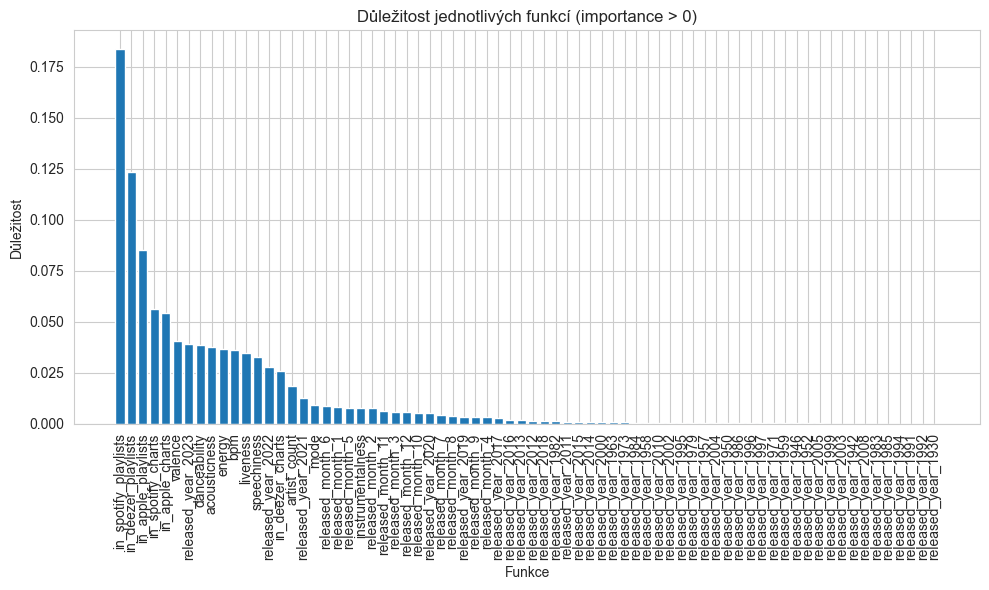

In [43]:
default_rf_clf = RandomForestClassifier(random_state=42)
cv_scores_default = cross_val_score(default_rf_clf, X_train, y_train, cv=kfold, scoring='f1_macro', n_jobs=-1)
print("Výchozí RandomForest:")
print("F1 skóre z křížové validace pro jednotlivé foldy (default):", cv_scores_default)
print("Průměrné F1 skóre (default):", cv_scores_default.mean())

default_rf_clf.fit(X_train, y_train)
y_pred_default = default_rf_clf.predict(X_test)

print("\nClassification Report na testovací sadě (default):")
print(classification_report(y_test, y_pred_default))


param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=kfold,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)


print("\nNejlepší parametry nalezené GridSearchCV:")
print(grid_search.best_params_)
print("Nejlepší F1 skóre na trénovací sadě (tuned):", grid_search.best_score_)


best_rf_clf = grid_search.best_estimator_
y_pred_tuned = best_rf_clf.predict(X_test)

print("\nClassification Report na testovací sadě (tuned):")
print(classification_report(y_test, y_pred_tuned))
plot_feature_importance(X_train, best_rf_clf)

## GradientBoosting

Výchozí GradientBoostingClassifier:
F1 skóre z křížové validace pro jednotlivé foldy (default): [0.67802318 0.65998464 0.6405303  0.71435897 0.72329783 0.60284658
 0.73593599]
Průměrné F1 skóre (default): 0.6792825005537694

Classification Report na testovací sadě (default):
              precision    recall  f1-score   support

     Average       0.58      0.62      0.60        48
Most Popular       0.84      0.81      0.83        47
     Popular       0.58      0.52      0.55        48
   Unpopular       0.73      0.77      0.75        48

    accuracy                           0.68       191
   macro avg       0.68      0.68      0.68       191
weighted avg       0.68      0.68      0.68       191

Fitting 7 folds for each of 54 candidates, totalling 378 fits

Nejlepší hyperparametry z GridSearch: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}

Tunovaný GradientBoostingClassifier:
F1 skóre z křížové validace pro jednotlivé foldy (tuned): [0.69485514 0

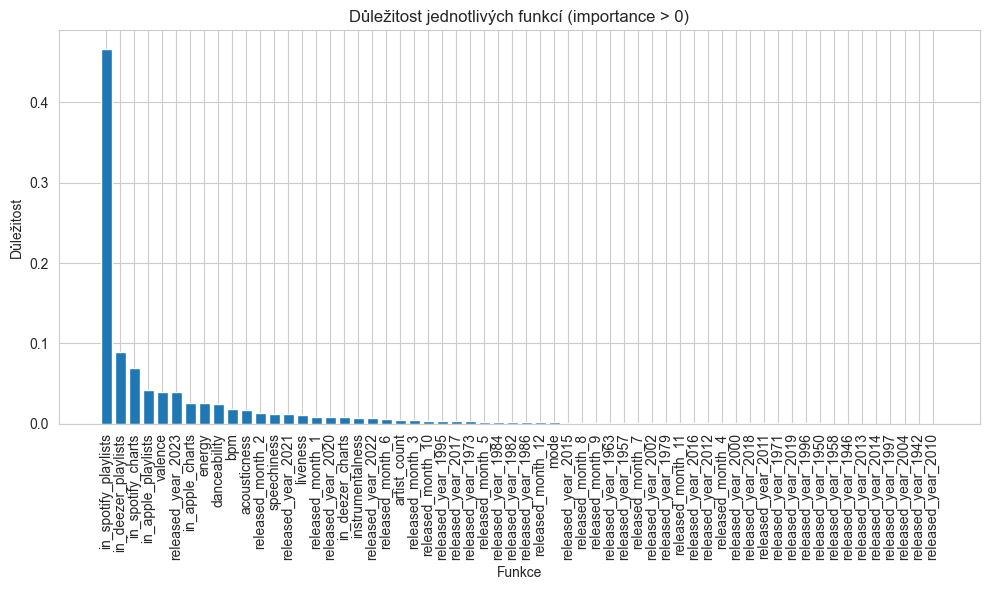

In [44]:
default_gb_clf = GradientBoostingClassifier(random_state=42)
cv_scores_default = cross_val_score(default_gb_clf, X_train, y_train, cv=kfold, scoring='f1_macro', n_jobs=-1)

print("Výchozí GradientBoostingClassifier:")
print("F1 skóre z křížové validace pro jednotlivé foldy (default):", cv_scores_default)
print("Průměrné F1 skóre (default):", cv_scores_default.mean())

default_gb_clf.fit(X_train, y_train)
y_pred_default = default_gb_clf.predict(X_test)

print("\nClassification Report na testovací sadě (default):")
print(classification_report(y_test, y_pred_default))

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=kfold,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_gb_clf = grid_search.best_estimator_

print("\nNejlepší hyperparametry z GridSearch:", best_params)

cv_scores_tuned = cross_val_score(best_gb_clf, X_train, y_train, cv=kfold, scoring='f1_macro', n_jobs=-1)

print("\nTunovaný GradientBoostingClassifier:")
print("F1 skóre z křížové validace pro jednotlivé foldy (tuned):", cv_scores_tuned)
print("Průměrné F1 skóre (tuned):", cv_scores_tuned.mean())

best_gb_clf.fit(X_train, y_train)
y_pred_tuned = best_gb_clf.predict(X_test)

print("\nClassification Report na testovací sadě (tuned):")
print(classification_report(y_test, y_pred_tuned))
plot_feature_importance(X_train, best_gb_clf)

## MLP Classifier

In [45]:
from sklearn.inspection import permutation_importance

def plot_permutation_importance(X_train, y_train, best_model):
    result = permutation_importance(best_model, X_train, y_train, scoring='f1_macro', n_repeats=10, random_state=42)
    feature_importances = result.importances_mean
    feature_names = X_train.columns

    indices = np.argsort(feature_importances)[::-1]
    
    print("\nDůležitost jednotlivých funkcí (Permutation Importance):")
    for i in indices:
        if feature_importances[i] > 0:
            print(f"{feature_names[i]}: {feature_importances[i]:.6f}")
    
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(indices)), feature_importances[indices], align="center")
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.title("Důležitost jednotlivých funkcí (Permutation Importance)")
    plt.xlabel("Funkce")
    plt.ylabel("Důležitost")
    plt.tight_layout()
    plt.show()

Výchozí MLPClassifier:
F1 skóre z křížové validace pro jednotlivé foldy (default): [0.6453373  0.65668016 0.54302838 0.68576889 0.67045253 0.64327922
 0.68429001]
Průměrné F1 skóre (default): 0.6469766431728198


d:\Programy\SU_klasifikace\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



Classification Report na testovací sadě (default):
              precision    recall  f1-score   support

     Average       0.52      0.48      0.50        48
Most Popular       0.85      0.85      0.85        47
     Popular       0.58      0.60      0.59        48
   Unpopular       0.72      0.75      0.73        48

    accuracy                           0.67       191
   macro avg       0.67      0.67      0.67       191
weighted avg       0.67      0.67      0.67       191

Fitting 7 folds for each of 96 candidates, totalling 672 fits


d:\Programy\SU_klasifikace\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



Nejlepší hyperparametry z GridSearch: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}

Tunovaný MLPClassifier:
F1 skóre z křížové validace pro jednotlivé foldy (tuned): [0.66795635 0.69251069 0.59985755 0.73867469 0.6851855  0.626318
 0.66449913]
Průměrné F1 skóre (tuned): 0.6678574155995439


d:\Programy\SU_klasifikace\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



Classification Report na testovací sadě (tuned):
              precision    recall  f1-score   support

     Average       0.49      0.44      0.46        48
Most Popular       0.78      0.85      0.82        47
     Popular       0.51      0.46      0.48        48
   Unpopular       0.69      0.77      0.73        48

    accuracy                           0.63       191
   macro avg       0.62      0.63      0.62       191
weighted avg       0.62      0.63      0.62       191


Důležitost jednotlivých funkcí (Permutation Importance):
in_spotify_playlists: 0.434578
in_spotify_charts: 0.182250
released_year_2023: 0.160816
in_apple_charts: 0.081140
in_deezer_playlists: 0.051356
energy: 0.051033
in_apple_playlists: 0.047606
released_year_2021: 0.045784
danceability: 0.043664
bpm: 0.036258
acousticness: 0.035783
liveness: 0.035254
speechiness: 0.032574
valence: 0.030619
in_deezer_charts: 0.028629
released_month_11: 0.022344
instrumentalness: 0.022211
released_year_2020: 0.019433
released

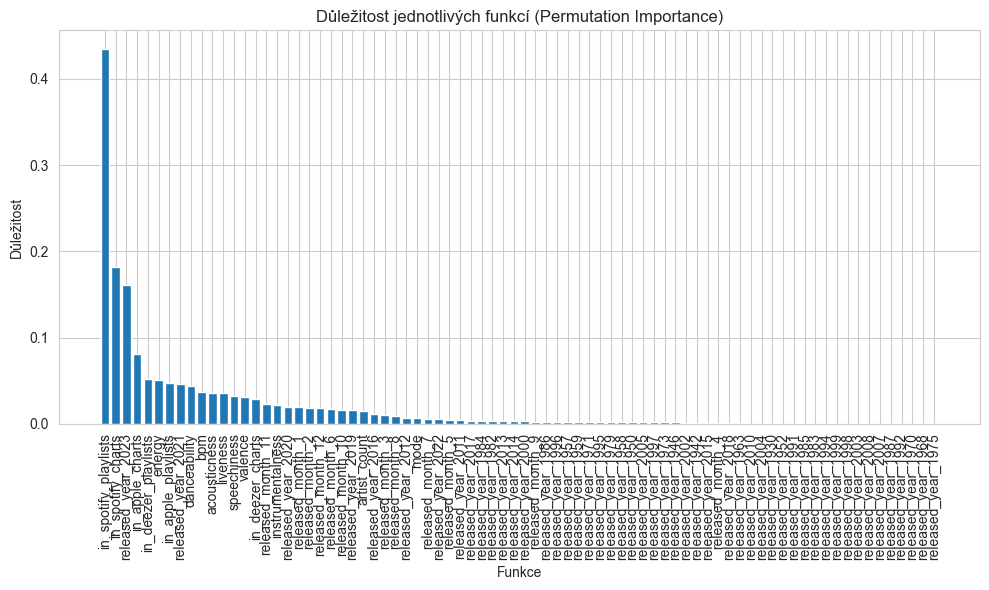

In [46]:
default_mlp_clf = MLPClassifier(random_state=42, max_iter=300)
cv_scores_default = cross_val_score(default_mlp_clf, X_train, y_train, cv=kfold, scoring='f1_macro', n_jobs=-1)

print("Výchozí MLPClassifier:")
print("F1 skóre z křížové validace pro jednotlivé foldy (default):", cv_scores_default)
print("Průměrné F1 skóre (default):", cv_scores_default.mean())

default_mlp_clf.fit(X_train, y_train)
y_pred_default = default_mlp_clf.predict(X_test)

print("\nClassification Report na testovací sadě (default):")
print(classification_report(y_test, y_pred_default))

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (50, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

grid_search = GridSearchCV(
    estimator=MLPClassifier(random_state=42, max_iter=300),
    param_grid=param_grid,
    scoring='f1_macro',
    cv=kfold,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_mlp_clf = grid_search.best_estimator_

print("\nNejlepší hyperparametry z GridSearch:", best_params)

cv_scores_tuned = cross_val_score(best_mlp_clf, X_train, y_train, cv=kfold, scoring='f1_macro', n_jobs=-1)

print("\nTunovaný MLPClassifier:")
print("F1 skóre z křížové validace pro jednotlivé foldy (tuned):", cv_scores_tuned)
print("Průměrné F1 skóre (tuned):", cv_scores_tuned.mean())

best_mlp_clf.fit(X_train, y_train)
y_pred_tuned = best_mlp_clf.predict(X_test)

print("\nClassification Report na testovací sadě (tuned):")
print(classification_report(y_test, y_pred_tuned))
plot_permutation_importance(X_train, y_train, best_mlp_clf)

# Závěrečné shrnutí

## Dataset a preprocessing
Zvolený dataset byl vhodně zvolen pro shlukování z důvodu velkého zastoupení numerických atributů, což výrazně ulehčilo celkový preprocessing datové sady.

Nejprve bylo zapotřebí provést explorační analýzu a odstranit z datasetu neplatný záznam.

Dále jsem určil, které z atributů jsou důležité pro shlukovací analýzu a zbylé jsem odstranil.

V neposlední řadě bylo nutné správně naformátovat sloupec pro atribut `in_deezer_playlists`.

Většina atributů měla exponenciální rozdělení, proto jsem zvolil úpravu s pomocí metody PowerTransform.

Pro hodnoty s normálním rozdělením jsem využil metodu **StandardScaler**.

# Výsledky modelů

| **Model**                  | **Průměrné F1 (default)** | **Průměrné F1 (tuned)** | **Přesnost (default)** | **Přesnost (tuned)** | **Nejlepší parametry (tuned)**                                                                                               |
|----------------------------|---------------------------|--------------------------|-------------------------|----------------------|----------------------------------------------------------------------------------------------------------------------------|
| **DecisionTreeClassifier** | 0.584                     | 0.643                    | 0.64                    | 0.60                 | `{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}` |
| **RandomForest**           | 0.683                     | 0.684                    | 0.64                    | 0.68                 | `{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}`                     |
| **GradientBoosting**       | 0.679                     | 0.695                    | 0.68                    | 0.67                 | `{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}`                                                      |
| **MLPClassifier**          | 0.647                     | 0.668                    | 0.67                    | 0.63                 | `{'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'constant', 'solver': 'adam'}`               |


## Závěry

1. **RandomForestClassifier**:
   - Dosáhl nejlepších výsledků jak v základní konfiguraci, tak i po ladění hyperparametrů.
   - Nejvyšší přesnost na testovací sadě byla 68 %, a vážený průměr F1 skóre také 68 %.
   - **RandomForest** se jeví jako nejspolehlivější model s ohledem na výkonnost.

2. **GradientBoostingClassifier**:
   - Velmi podobné výsledky jako RandomForest, s mírně vyšším F1 skórem v laděné variantě při cross-validaci.
   - Přesnost na testovací sadě však klesla z 68 % na 67 %.

3. **DecisionTreeClassifier**:
   - Výchozí konfigurace dosáhla nejnižšího výkonu ve srovnání s ostatními modely, přičemž F1 skóre a přesnost se pohybují kolem 60 %.
   - I po ladění hyperparametrů tento model nedosahuje lepších výsledků než RandomForest nebo GradientBoosting.

4. **MLPClassifier**:
   - Výchozí konfigurace měla poměrně dobré výsledky (67 % přesnost, 67 % vážený průměr F1 skóre).
   - Po ladění hyperparametrů však došlo k mírnému zhoršení výkonu na testovací sadě (63 % přesnost, 62 % vážený průměr F1 skóre).

5. **Ladění hyperparametrů**:
   - Ladění přineslo zlepšení zejména u **GradientBoostingClassifier** a **RandomForest** (vyšší F1 skóre v cross-validaci).
   - U ostatních modelů ladění nevedlo k výraznějšímu nárůstu výkonu na testovací sadě.

6. **Doporučení**:
   - **RandomForestClassifier** by měl být preferován pro tento dataset, protože vykazuje nejlepší a nejstabilnější výkon.
   - Pro další zlepšení lze zkusit kombinaci modelů (ensemble metody) nebo pokročilejší techniky ladění hyperparametrů.